In [106]:
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import os

load_dotenv()

assert os.getenv("OPENAI_API_KEY") is not None

client = OpenAI()

def get_assistant_msg(content: str):
    return {"role": "assistant",
            "content": content}

def pipe_qa_chat(trial: str, base_messages: list, summary_prompt: str, model: str, tool_data: dict, questions = None):
    trial_message = {"role": "user",
                     "content": f"The trial data is the following.\n{trial}\nLet's explain this clinical trial for predicting its success. Let's examine, step by step."}
    
    base_messages.append(trial_message)
    history = base_messages
    response = get_assistant_msg(get_response(history, model, None))
    history.append(response)

    for question in questions:
        history.append(question)
        messages = base_messages + [question]
        response = get_assistant_msg(get_response(messages, model, None))
        history.append(response)

    summary_message = {"role": "user",
                       "content": f"{summary_prompt} With that in mind, predict the outcome of this clinical trial. Let's examine, step by step."}
    
    response = get_response(history + [summary_message], model, tool_data)

    full_history =  history + [summary_message, response]
    for message in full_history:
        print(message)

    return response


def get_response(messages: list, model: str, tool_data: dict):

    if tool_data is not None:
        tools = [
            {
                "type": "function",
                "function": {
                    "name": "predict_trial_outcome",
                    "description": tool_data.get("description"),
                    "parameters": tool_data.get("parameters")
                }
            }
        ]
    
        completion = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=tools,
            tool_choice="auto"
        )

    else:
        completion = client.chat.completions.create(
            model=model,
            messages=messages
        )

    assert completion.choices is not None

    message = completion.choices[0].message
    if message.tool_calls is not None:
        tool_calls = message.tool_calls
        response = tool_calls[0].function.arguments
    else:
        response = message.content

    if response is None:
        raise ValueError(f"Invalid response structure: {completion}")

    return response


def serialize_row(row: pd.Series) -> str:
    return ", ".join(f"{colname} is {value if value is not None else 'unknown'}" for colname, value in row.items()) + "."

In [107]:
import tiktoken

def get_pricing(direction, model, text):
    assert (model == "gpt-3.5-turbo" or model ==
            "gpt-4-0125-preview") and (direction == "in" or direction == "out")
    encoder = tiktoken.encoding_for_model(model)
    token_cnt = len(encoder.encode(text))
    if direction == "in":
        return (token_cnt * 0.01 / 1e3 if model == "gpt-4-0125-preview" else token_cnt * 0.0005 / 1e3)
    else:
        return (token_cnt * 0.03 / 1e3 if model == "gpt-4-0125-preview" else token_cnt * 0.0015 / 1e3)

In [108]:
from pytrial.data.demo_data import load_trial_outcome_data
from pytrial.data.trial_data import TrialOutcomeDatasetBase

df = load_trial_outcome_data(phase='I', split='test')['data']

test_data = TrialOutcomeDatasetBase(df).data

outcomes = test_data[['nctid', 'label', 'why_stop', 'status']]
test_data.drop(['smiless', 'label', 'why_stop',
               'study_first_submitted_date', 'nctid', 'status'], axis=1, inplace=True)

serialized_trials = test_data.apply(serialize_row, axis=1)

In [109]:
results_folder = "../results"
results_file = "predictions-subtasks+clinical_knowledge.json"
model = "gpt-3.5-turbo"
limit = 50

In [110]:
import traceback
from tqdm import tqdm
import json
from datetime import datetime

with open("prompts.json", "r") as file:
    prompts = json.load(file)

prompt = prompts['templates']['subtasks+clinical_knowledge']

base_messages = prompt['base_messages']
summary_prompt = prompt['summary_prompt']
tool_data = prompt['tool_data']
questions = prompt['questions']


with open(f"{results_folder}/{results_file}", "w") as file:
    json.dump([], file)

def process_trial(trial, outcome):
    idx, outcome = outcome
    
    try:
        res = pipe_qa_chat(
            trial, base_messages, summary_prompt, model, tool_data, questions)

        response = json.loads(res) if isinstance(res, str) else res
        response['ground_truth'] = "success" if outcome.get(
            'label') == 1 else "failure"
        response['nctid'] = outcome.get('nctid')

        with open(f"{results_folder}/{results_file}", "r+") as file:
            file_data = json.load(file)
            file_data.append(response)
            file.seek(0)
            json.dump(file_data, file, indent=4)
            file.truncate()

    except Exception as e:
        print(f"Error processing trial {outcome.get('nctid', 'Unknown')}: {e}")
        log_error(e, outcome)


def log_error(exception, outcome):
    error_message = {
        "trial_id": outcome.get('nctid', 'unknown'),
        "error": str(exception),
        "stack_trace": traceback.format_exc(),
        "time": datetime.now().isoformat()
    }

    with open(f"{results_folder}/error_log.json", "a+") as error_file:
        error_file.seek(0)
        try:
            errors = json.load(error_file)
        except json.JSONDecodeError:
            errors = []
        errors.append(error_message)
        error_file.seek(0)
        json.dump(errors, error_file, indent=4)
        error_file.truncate()

for trial, outcome in tqdm(zip(serialized_trials[:limit], outcomes.iterrows())):
    process_trial(trial, outcome)

1it [00:36, 36.66s/it]

{'role': 'user', 'content': 'You are an expert in clinical pharmacology, tasked with examining which clinical trials are worthy of investment, and which ones have a higher likelihood of failure. In spite of time-consuming processes and high costs, the overall success rate of clinical trials is only 7.9%, which is a high risk for biopharmaceutical companies.\nThe four most important success factors according to research are the following: quality of clinical trials, speed of clinical trials, relationship type, and communication.'}
{'role': 'assistant', 'content': "Evaluating clinical trials for investment involves a nuanced understanding of the factors that influence their success. Given the low overall success rate of 7.9%, it's crucial to scrutinize these factors closely to mitigate financial risks and maximize the potential for positive outcomes. Here's a breakdown of the key success factors, and how they impact the likelihood of clinical trial success: ### Quality of Clinical Trials

2it [01:19, 40.55s/it]

{'role': 'user', 'content': 'You are an expert in clinical pharmacology, tasked with examining which clinical trials are worthy of investment, and which ones have a higher likelihood of failure. In spite of time-consuming processes and high costs, the overall success rate of clinical trials is only 7.9%, which is a high risk for biopharmaceutical companies.\nThe four most important success factors according to research are the following: quality of clinical trials, speed of clinical trials, relationship type, and communication.'}
{'role': 'assistant', 'content': "Evaluating clinical trials for investment involves a nuanced understanding of the factors that influence their success. Given the low overall success rate of 7.9%, it's crucial to scrutinize these factors closely to mitigate financial risks and maximize the potential for positive outcomes. Here's a breakdown of the key success factors, and how they impact the likelihood of clinical trial success: ### Quality of Clinical Trials

3it [02:04, 42.50s/it]

{'role': 'user', 'content': 'You are an expert in clinical pharmacology, tasked with examining which clinical trials are worthy of investment, and which ones have a higher likelihood of failure. In spite of time-consuming processes and high costs, the overall success rate of clinical trials is only 7.9%, which is a high risk for biopharmaceutical companies.\nThe four most important success factors according to research are the following: quality of clinical trials, speed of clinical trials, relationship type, and communication.'}
{'role': 'assistant', 'content': "Evaluating clinical trials for investment involves a nuanced understanding of the factors that influence their success. Given the low overall success rate of 7.9%, it's crucial to scrutinize these factors closely to mitigate financial risks and maximize the potential for positive outcomes. Here's a breakdown of the key success factors, and how they impact the likelihood of clinical trial success: ### Quality of Clinical Trials

4it [03:00, 47.92s/it]

{'role': 'user', 'content': 'You are an expert in clinical pharmacology, tasked with examining which clinical trials are worthy of investment, and which ones have a higher likelihood of failure. In spite of time-consuming processes and high costs, the overall success rate of clinical trials is only 7.9%, which is a high risk for biopharmaceutical companies.\nThe four most important success factors according to research are the following: quality of clinical trials, speed of clinical trials, relationship type, and communication.'}
{'role': 'assistant', 'content': "Evaluating clinical trials for investment involves a nuanced understanding of the factors that influence their success. Given the low overall success rate of 7.9%, it's crucial to scrutinize these factors closely to mitigate financial risks and maximize the potential for positive outcomes. Here's a breakdown of the key success factors, and how they impact the likelihood of clinical trial success: ### Quality of Clinical Trials

5it [03:32, 42.19s/it]

Error processing trial NCT01657760: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 16539 tokens (16374 in the messages, 165 in the functions). Please reduce the length of the messages or functions.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


6it [03:35, 28.64s/it]

Error processing trial NCT01746784: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 16890 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


7it [03:57, 26.50s/it]

Error processing trial NCT01799161: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 17687 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


In [62]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix, accuracy_score, f1_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder

preds = pd.read_json(f"{results_folder}/{results_file}")

preds['prediction'] = preds['prediction'].apply(
    lambda x: 'failure' if x != 'success' else 'success')
preds['ground_truth'] = preds['ground_truth'].apply(
    lambda x: 'failure' if x != 'success' else 'success')

le = LabelEncoder()
y_true = le.fit_transform(preds['ground_truth'])
y_pred = le.transform(preds['prediction'])


def calculate_metrics(y_true, y_pred):
    metrics = {}
    metrics['Acc'] = accuracy_score(y_true, y_pred)
    metrics['F1'] = f1_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred)
    metrics['PR-AUC'] = average_precision_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['Specificity'] = tn / (tn + fp)

    return metrics


metrics = calculate_metrics(y_true, y_pred)
print(metrics)

{'Acc': 0.54, 'F1': 0.6567164179104478, 'Precision': 0.55, 'Recall': 0.8148148148148148, 'ROC-AUC': 0.5161030595813204, 'PR-AUC': 0.5481481481481483, 'Specificity': 0.21739130434782608}


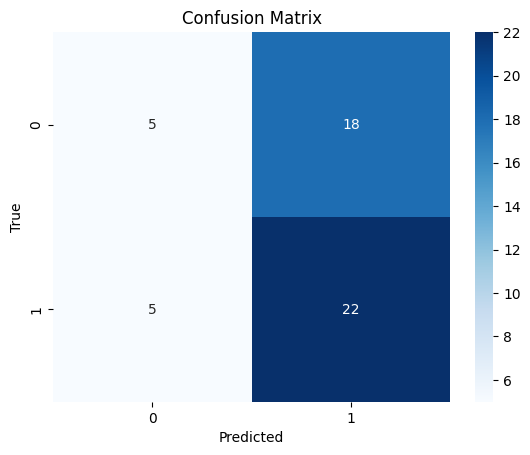

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

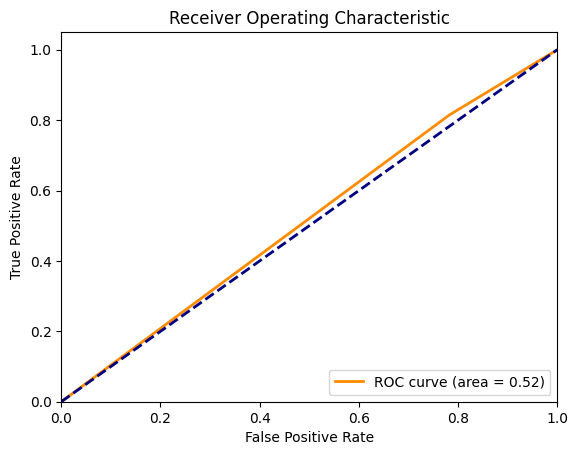

In [64]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()